In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
import pandas as pd
df = pd.read_csv("../Outliers.csv")

In [82]:
data = df
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
np.random.seed(7)

# load the dataset
dataframe = data[["Price"]]
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset (faster reduction of MSE when optimising)
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# reshape into X=t and Y=t+1
look_back = 3
X, Y = create_dataset(dataset, look_back)

# reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))


In [43]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X, Y, epochs=100, batch_size=1, verbose=2)
model.save("LSTM-copy")

Epoch 1/100
 - 3s - loss: 0.0018
Epoch 2/100
 - 2s - loss: 0.0018
Epoch 3/100
 - 2s - loss: 0.0018
Epoch 4/100
 - 2s - loss: 0.0018
Epoch 5/100
 - 2s - loss: 0.0018
Epoch 6/100
 - 2s - loss: 0.0017
Epoch 7/100
 - 2s - loss: 0.0017
Epoch 8/100
 - 2s - loss: 0.0017
Epoch 9/100
 - 2s - loss: 0.0017
Epoch 10/100
 - 2s - loss: 0.0017
Epoch 11/100
 - 2s - loss: 0.0017
Epoch 12/100
 - 2s - loss: 0.0017
Epoch 13/100
 - 1s - loss: 0.0017
Epoch 14/100
 - 1s - loss: 0.0017
Epoch 15/100
 - 2s - loss: 0.0017
Epoch 16/100
 - 2s - loss: 0.0017
Epoch 17/100
 - 2s - loss: 0.0017
Epoch 18/100
 - 1s - loss: 0.0017
Epoch 19/100
 - 2s - loss: 0.0017
Epoch 20/100
 - 2s - loss: 0.0017
Epoch 21/100
 - 2s - loss: 0.0017
Epoch 22/100
 - 2s - loss: 0.0017
Epoch 23/100
 - 2s - loss: 0.0017
Epoch 24/100
 - 2s - loss: 0.0017
Epoch 25/100
 - 2s - loss: 0.0017
Epoch 26/100
 - 2s - loss: 0.0017
Epoch 27/100
 - 2s - loss: 0.0017
Epoch 28/100
 - 2s - loss: 0.0017
Epoch 29/100
 - 1s - loss: 0.0017
Epoch 30/100
 - 2s - lo

In [17]:
# test model import
#reconstructed_model = load_model("LSTM-copy")
#Predict = reconstructed_model.predict(X)

In [83]:
# make predictions
Predict = model.predict(X)

# invert predictions
Predict = scaler.inverse_transform(Predict)
Y = scaler.inverse_transform([Y])

# calculate root mean squared error
Score = np.sqrt(mean_squared_error(Y, Predict[:,0]))
print('Score: %.2f RMSE' % (Score))

# shift predictions for plotting
PredictPlot = np.empty_like(dataset)
PredictPlot[:, :] = np.nan
PredictPlot[look_back:len(Predict)+look_back, :] = Predict
df["Predictions"] = PredictPlot

ValueError: Found input variables with inconsistent numbers of samples: [1, 580]

<AxesSubplot:>

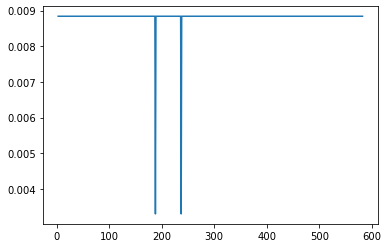

In [81]:
# plot baseline and predictions
fig, ax = plt.subplots()
#df.Price.drop(df[df.Price > 10000].index).plot(ax=ax)
df.Predictions.plot(ax=ax)

In [38]:
df["Residuals"] = df.Price - df.Predictions
resiStats = df.Residuals.describe()
IQR = resiStats[6] - resiStats[4]
lowerBound, upperBound = resiStats[4] - 1.5* IQR, resiStats[6] + 1.5* IQR
df["Anomaly"] = (df.Residuals > upperBound) | (df.Residuals < lowerBound)

In [28]:
fig, ax = plt.subplots()
df[["Price"]].drop(df.Price[df.Anomaly == True].index).plot(ax=ax, color="b")
df.Price.drop(df[df.Residuals == df.Residuals.max()].index).plot(ax=ax, style="--", color="orange")


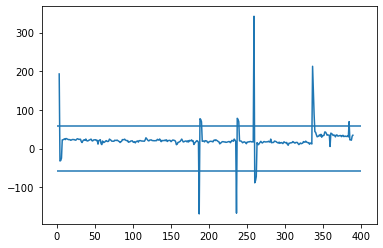

In [53]:
fig, ax = plt.subplots()
data.residuals.plot(ax=ax)
ax.hlines(2*data.residuals.std(), 0, 400)
ax.hlines(-2*data.residuals.std(), 0, 400)

<AxesSubplot:>

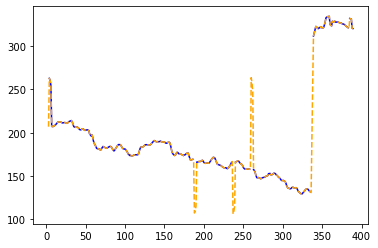

In [107]:
fig, ax = plt.subplots()
data["cleaned"] = data.Train.drop(data[data.residuals > 2*data.residuals.std()].index).drop(data[data.residuals < -2*data.residuals.std()].index)
data.cleaned.plot(ax=ax, label="cleaned", color='b')
data.Train.plot(ax=ax, label="Train", style = "--" , color='orange')

,Date,Price,Train,Test,residuals,cleaned
0,09/12/2017,229.40,NaN,NaN,NaN,NaN
1,10/12/2017,229.40,NaN,NaN,NaN,NaN
2,11/12/2017,230.50,NaN,NaN,NaN,NaN
3,12/12/2017,400.10,207.07988,NaN,193.02012,NaN
4,13/12/2017,230.90,262.82489,NaN,-31.92489,262.82489
...,...,...,...,...,...,...
579,12/07/2019,331.74,NaN,291.086212,NaN,NaN
580,13/07/2019,331.74,NaN,291.563293,NaN,NaN
581,14/07/2019,331.74,NaN,300.530701,NaN,NaN
582,15/07/2019,330.20,NaN,300.319244,NaN,NaN


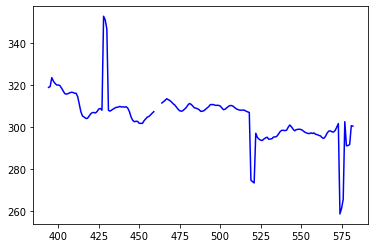

In [150]:
data["temp"] = data.Price - data.Test

data["ct"] = data.Test.drop(data[data.temp > 2*data.temp.std()].index).drop(data[data.temp < -2*data.temp.std()].index)

fig, ax = plt.subplots()
data.ct.plot(ax=ax, label="ct", color='b')
#data.Test.drop(data.Test[data.Test < 1000].index).plot(ax=ax, label="Test", style = "--" , color='orange')

data.drop(["temp", "ct"], axis=1, inplace=True)
data